In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip3 install nlpaug
import tarfile
from wordcloud import WordCloud, STOPWORDS
import re
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint 
import datetime
from tensorflow import keras

In [58]:
# !curl --header "Host: www.cl.cam.ac.uk" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-GB,en;q=0.9" --header "Referer: https://www.cl.cam.ac.uk/research/nl/bea2019st/" "https://www.cl.cam.ac.uk/research/nl/bea2019st/data/fce_v2.1.bea19.tar.gz" -L -o "fce_v2.1.bea19.tar.gz"

In [59]:
import tarfile
fname='D:/sentence correction 2/fce_v2.1.bea19.tar.gz'
fname.endswith("tar.gz")
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

In [60]:
def m2_to_txt(path):
  '''
  this function processes the .m2 format file 
  and converts the required sentence into txt format'''
  m2 = open(path).read().strip().split("\n\n")
  corrupted = open('corrupted.txt', "w")
  uncorrupted=open('uncorrupted.txt','w')
  skip = {"noop", "UNK", "Um"}
  for sent in m2:
    sent=sent.split('\n')
  
    incorr_sent=sent[0].split()[1:]
  
    corrupted.write(" ".join(incorr_sent)+"\n")
    edits = sent[1:]
  
    offset=0
  
    for edit in edits:
        edit = edit.split("|||")
        if edit[1] in skip: continue # Ignore certain edits
        
        
        span = edit[0].split()[1:] # Ignore "A "
        start = int(span[0])
        end = int(span[1])
        cor = edit[2].split()
        incorr_sent[start+offset:end+offset] = cor
    
        offset = offset-(end-start)+len(cor)
      
    uncorrupted.write(" ".join(incorr_sent)+"\n")

In [61]:
m2_to_txt('D:/sentence correction 2/fce/m2/fce.dev.gold.bea19.m2')
with open('uncorrupted.txt','r') as file:
  uncorrupted=[]
  line=file.readlines()
  for lines in line:
    uncorrupted.append(" ".join(lines.split()[:len(lines)]))
with open('corrupted.txt','r') as file:
  corrupted=[]
  line=file.readlines()
  for lines in line:
    corrupted.append(" ".join(lines.split()[:len(lines)]))

data1=pd.DataFrame(zip(corrupted,uncorrupted),columns=['corrupted','uncorrupted'])

m2_to_txt('D:/sentence correction 2/fce/m2/fce.train.gold.bea19.m2')
with open('uncorrupted.txt','r') as file:
  uncorrupted=[]
  line=file.readlines()
  for lines in line:
    uncorrupted.append(" ".join(lines.split()[:len(lines)]))
with open('corrupted.txt','r') as file:
  corrupted=[]
  line=file.readlines()
  for lines in line:
    corrupted.append(" ".join(lines.split()[:len(lines)]))

data2=pd.DataFrame(zip(corrupted,uncorrupted),columns=['corrupted','uncorrupted'])

m2_to_txt('D:/sentence correction 2/fce/m2/fce.test.gold.bea19.m2')
with open('uncorrupted.txt','r') as file:
  uncorrupted=[]
  line=file.readlines()
  for lines in line:
    uncorrupted.append(" ".join(lines.split()[:len(lines)]))
with open('corrupted.txt','r') as file:
  corrupted=[]
  line=file.readlines()
  for lines in line:
    corrupted.append(" ".join(lines.split()[:len(lines)]))

data3=pd.DataFrame(zip(corrupted,uncorrupted),columns=['corrupted','uncorrupted'])



In [62]:
data=pd.concat([data1, data2, data3],ignore_index=True)

In [63]:
data=data[data['corrupted']!=data['uncorrupted']]#removing rows which have same values in both columns

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20877 entries, 3 to 33235
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   corrupted    20877 non-null  object
 1   uncorrupted  20877 non-null  object
dtypes: object(2)
memory usage: 489.3+ KB


In [65]:

fname='sm_norm_mt.tar.gz'
fname.endswith("tar.gz")
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

In [66]:
with open('D:/sentence correction 2/release/en2cn-2k.en2nen2cn','r') as file:
  line=file.readlines()
corrupted=[]
uncorrupted=[]
for i,lines in enumerate(line):
  if i%3==0:
    corrupted.append(lines.strip())
  elif (i%3==1):
    uncorrupted.append(lines.strip())
  else:
    pass

In [67]:
data4=pd.DataFrame(zip(corrupted,uncorrupted),columns=['corrupted','uncorrupted'])

In [68]:
data4.head()

,corrupted,uncorrupted
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


In [69]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   corrupted    2000 non-null   object
 1   uncorrupted  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [70]:
data= data.sample(frac=1).reset_index(drop=True)

In [71]:
data=data.drop_duplicates()

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20629 entries, 0 to 20876
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   corrupted    20629 non-null  object
 1   uncorrupted  20629 non-null  object
dtypes: object(2)
memory usage: 483.5+ KB


#CHECKING FOR WORD LENGTHS FOR BOTH COLUMN

In [73]:
word_len_corrupt=data['corrupted'].str.split().str.len()

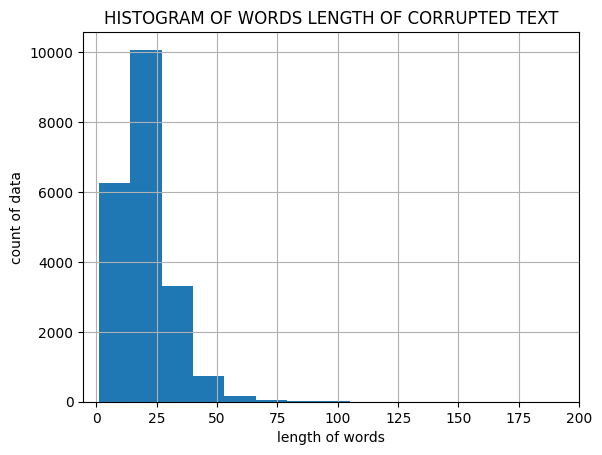

In [74]:
plt.hist(word_len_corrupt)
plt.xticks(range(0,225,25))
plt.grid()
plt.xlabel("length of words")
plt.ylabel('count of data')
plt.title("HISTOGRAM OF WORDS LENGTH OF CORRUPTED TEXT")
plt.show()

#CONCLUSION--
    1.THERE ARE VERY MUCH LESS WORDS HAVING LENGTH GREATER THAN 75
    2.THERE ARE MORE THAN 40000 WORDS HAVING LENGTH BETWEEN 0 AND 23
    3.THE WORD LENGTH RESEMBLES A RIGHT SKEWED DISTRIBUTION
    4.MOST OF THE WORDS HAVE LENGTH BETWEEN 0 TP 48
    5.THE MORE THE WORDS IN A SENTENCE MORE TIME IT WILL TAKE TO RUN THE MODEL..SINCE IT WILL TAKE MORE TIME TO UNRAVEL IN LSTM'S.

In [75]:
word_len_uncorrupt=data['uncorrupted'].str.split().str.len()

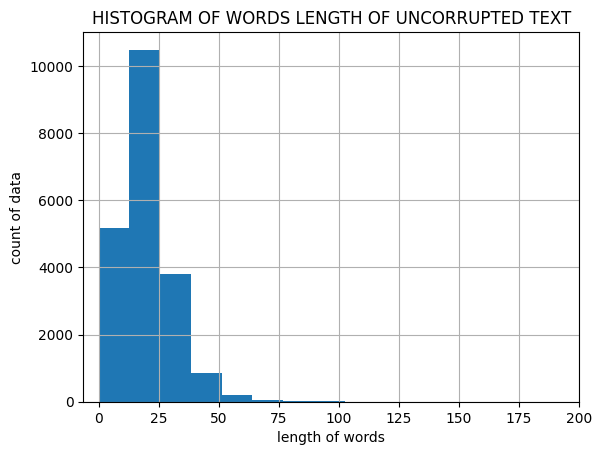

In [76]:
plt.hist(word_len_uncorrupt)
plt.xticks(range(0,225,25))
plt.grid()
plt.xlabel("length of words")
plt.ylabel('count of data')
plt.title("HISTOGRAM OF WORDS LENGTH OF UNCORRUPTED TEXT")
plt.show()

#CONCLUSION--
    1.THERE ARE VERY MUCH LESS WORDS HAVING LENGTH GREATER THAN 75
    2.THERE ARE MORE THAN 40000 WORDS HAVING LENGTH BETWEEN 0 AND 50
    3.THE WORD LENGTH RESEMBLES A RIGHT SKEWED DISTRIBUTION
    4.MOST OF THE WORDS HAVE LENGTH BETWEEN 0 TO 48

#PERCENTILES OF WORD LENGTH

##FOR CORRUPTED DATA

In [77]:
for i in range(0,101,10):
    print("{} percentile is: {}".format(i,np.percentile(word_len_corrupt, i)))

0 percentile is: 1.0
10 percentile is: 9.0
20 percentile is: 11.0
30 percentile is: 13.0
40 percentile is: 16.0
50 percentile is: 18.0
60 percentile is: 20.0
70 percentile is: 23.0
80 percentile is: 27.0
90 percentile is: 33.0
100 percentile is: 131.0


In [78]:
for i in range(90,101):
    print("{} percentile is: {}".format(i,np.percentile(word_len_corrupt, i)))

90 percentile is: 33.0
91 percentile is: 34.0
92 percentile is: 35.0
93 percentile is: 36.0
94 percentile is: 37.0
95 percentile is: 39.0
96 percentile is: 41.0
97 percentile is: 44.0
98 percentile is: 47.0
99 percentile is: 53.0
100 percentile is: 131.0


In [79]:
list=[99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]
for i in list:
    print("{} percentile is: {}".format(i,np.percentile(word_len_corrupt, i)))

99.1 percentile is: 54.0
99.2 percentile is: 56.0
99.3 percentile is: 57.0
99.4 percentile is: 59.0
99.5 percentile is: 60.86000000000058
99.6 percentile is: 63.0
99.7 percentile is: 67.11599999999817
99.8 percentile is: 74.0
99.9 percentile is: 79.37200000000303
100 percentile is: 131.0


##FOR UNCORRUPTED DATA

In [80]:
for i in range(0,101,10):
    print("{} percentile is: {}".format(i,np.percentile(word_len_uncorrupt, i)))

0 percentile is: 0.0
10 percentile is: 9.0
20 percentile is: 11.0
30 percentile is: 14.0
40 percentile is: 16.0
50 percentile is: 18.0
60 percentile is: 21.0
70 percentile is: 23.0
80 percentile is: 27.0
90 percentile is: 33.0
100 percentile is: 128.0


In [81]:
for i in range(90,101):
    print("{} percentile is: {}".format(i,np.percentile(word_len_uncorrupt, i)))

90 percentile is: 33.0
91 percentile is: 34.0
92 percentile is: 35.0
93 percentile is: 36.0
94 percentile is: 38.0
95 percentile is: 39.0
96 percentile is: 42.0
97 percentile is: 44.0
98 percentile is: 48.0
99 percentile is: 54.0
100 percentile is: 128.0


#WORD CLOUD:

In [82]:
def length(x):
  '''
  creating own function to calculate length of list
  '''
  count=0
  for i in x:
    count+=1
  return count

In [83]:

def word_cloud(df,col):

    comment_words = '' 
    stopwords = set(STOPWORDS) 

# iterate through the csv file 
    for val in df[col]:
        val = str(val) 
    # split the value 
        tokens = val.split() 
        
    # Converts each token into lowercase 
        for i in range(len(tokens)): #used my own funtion for calcluating length of list...since the inbuilt len() was giving error!
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image
    plt.figure(figsize = (8,8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("WORD CLOUD")
    plt.show()

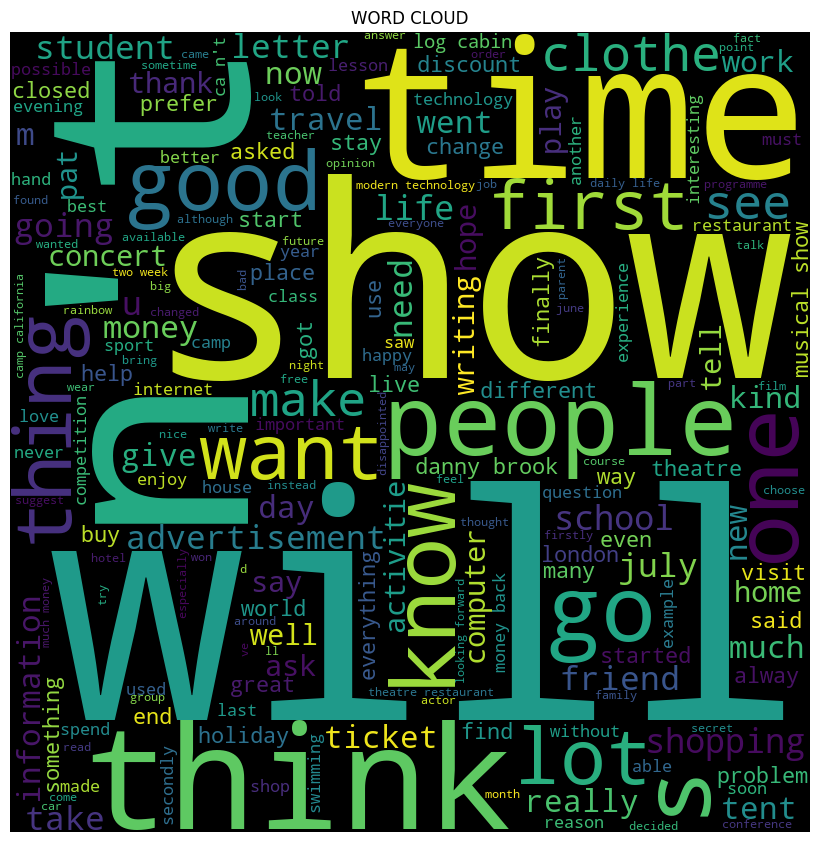

In [84]:
word_cloud(data,'corrupted')

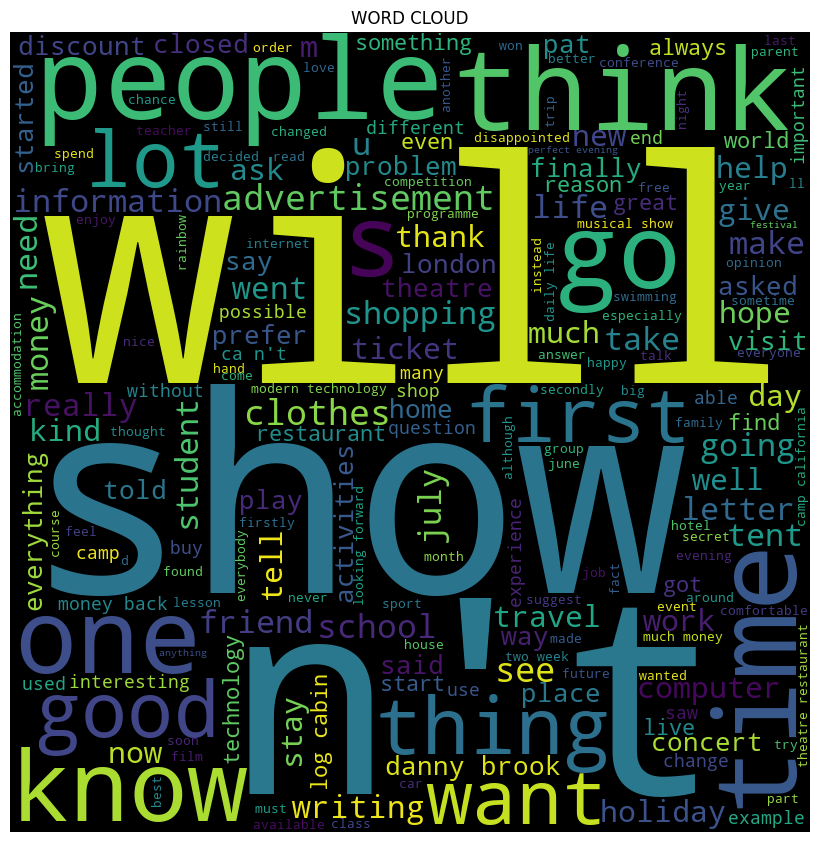

In [85]:
word_cloud(data,'uncorrupted')

#CONCLUSION--
    1.WORDS LIKE 'PEOPLE','TRANSPORT','PUBLIC' OCCURES MOSR FREQUENTLY..IN BOTH COLUMNS OF DATA..AND THEY ARE CORRECTLY SPEELLED...SO MOST OF OUR DATA WOULD CONTAIN EITHER GRAMATICAL ERRORS OR SMALL TENSE AND SPELLING MISMATCH


#PREPROCESSING

##CLEANING THE DATASET

In [86]:

def decontractions(phrase):
  """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""

  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"won\’t", "will not", phrase)
  phrase = re.sub(r"can\’t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)

  return phrase

In [87]:
data['corrupted']=data['corrupted'].apply(lambda x:decontractions(x))
data['uncorrupted']=data['uncorrupted'].apply(lambda x:decontractions(x))

data4['corrupted']=data4['corrupted'].apply(lambda x:decontractions(x))
data4['uncorrupted']=data4['uncorrupted'].apply(lambda x:decontractions(x))

##CONVERTING TO LOWER CASE

In [88]:
data['corrupted']=data['corrupted'].apply(lambda x:x.lower())
data['uncorrupted']=data['uncorrupted'].apply(lambda x:x.lower())

data4['corrupted']=data4['corrupted'].apply(lambda x:x.lower())
data4['uncorrupted']=data4['uncorrupted'].apply(lambda x:x.lower())

##CONSIDERING SENTENCES WITH WORD_LENGTH<25 AS PER PERCENTILES..

In [89]:
data['corrupted_len'] = data['corrupted'].str.split().apply(len)
data = data[data['corrupted_len'] < 25]

data['uncorrupted_len'] = data['uncorrupted'].str.split().apply(len)
data = data[data['uncorrupted_len'] < 25]

data4['corrupted_len'] = data4['corrupted'].str.split().apply(len)
data4 = data4[data4['corrupted_len'] < 25]

data4['uncorrupted_len'] = data4['uncorrupted'].str.split().apply(len)
data4 = data4[data4['uncorrupted_len'] < 25]

##ADDING 'START' AND 'END' TOKEN.

In [90]:
data['uncorrupted_inp']=data['uncorrupted'].apply(lambda x:('<START>'+' '+x))
data['uncorrupted_op']=data['uncorrupted'].apply(lambda x:(x+' '+'<END>'))
data.drop(['uncorrupted'],axis=1,inplace=True)

data4['uncorrupted_inp']=data4['uncorrupted'].apply(lambda x:('<START>'+' '+x))
data4['uncorrupted_op']=data4['uncorrupted'].apply(lambda x:(x+' '+'<END>'))
data4.drop(['uncorrupted'],axis=1,inplace=True)

In [91]:
data.drop(['corrupted_len','uncorrupted_len'],axis=1,inplace=True)
data4.drop(['corrupted_len','uncorrupted_len'],axis=1,inplace=True)

##SPLITTING DATASET

In [92]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1675 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   corrupted        1675 non-null   object
 1   uncorrupted_inp  1675 non-null   object
 2   uncorrupted_op   1675 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [93]:
# data=data.sample(5000)

In [94]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [95]:
train.shape

(11944, 3)

In [96]:
train=pd.concat([train,data4.iloc[0:1500]],ignore_index=True).astype(str)
validation=pd.concat([validation,data4.iloc[1500:1676]],ignore_index=True).astype(str)

In [147]:
validation.iloc[2]['corrupted']

'i ignored her i could  not do anything now .'

In [98]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['uncorrupted_inp']= str(train.iloc[0]['uncorrupted_inp'])+' <end>'
train.iloc[0]['uncorrupted_out']= str(train.iloc[0]['uncorrupted_op'])+' <end>'

(13444, 3) (3161, 3)


C:\Users\Shivam\AppData\Local\Temp\ipykernel_41280\3666877369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.iloc[0]['uncorrupted_inp']= str(train.iloc[0]['uncorrupted_inp'])+' <end>'
C:\Users\Shivam\AppData\Local\Temp\ipykernel_41280\3666877369.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.iloc[0]['uncorrupted_out']= str(train.iloc[0]['uncorrupted_op'])+' <end>'
C:\Users\Shivam\AppData\Local\Temp\ipykernel_41280\3666877369.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [99]:
train.sample(frac=1)

,corrupted,uncorrupted_inp,uncorrupted_op
6161,for your free hours i have quite a few ideas .,<START> for your free time i have quite a few ...,for your free time i have quite a few ideas . ...
6309,in the afternoon we go shopping how you have o...,<START> in the afternoon we go shopping how yo...,in the afternoon we go shopping how you have o...
5973,we talked for all night and i fall in love wit...,<START> we talked all night and i fell in love...,we talked all night and i fell in love with hi...
4399,our college is not much far away .,<START> our college is not very far away .,our college is not very far away . <END>
8287,i should say that it was the easiest and more ...,<START> i should say that it was the easiest a...,i should say that it was the easiest and most ...
...,...,...,...
7822,"so , what did the phone - revolution for us ?","<START> so , what has the phone revolution don...","so , what has the phone revolution done for us..."
1721,also deck shoes and a waterproof jacket for sa...,<START> also deck shoes and a waterproof jacke...,also deck shoes and a waterproof jacket for sa...
4311,i am writing for explaining some problems your...,<START> i am writing to explain some problems ...,i am writing to explain some problems your the...
12849,i reached already,<START> i reached already.,i reached already. <END>


##TOKENIZING THE DATA 

In [100]:
from tensorflow.keras.preprocessing.text import Tokenizer
tok_corrupted=Tokenizer(filters='#$%&()*+-/=@[\\]^_`{|}~\t\n')
tok_corrupted.fit_on_texts(train['corrupted'].values)

tok_uncorrupted=Tokenizer(filters='#$%&()*+-/=@[\\]^_`{|}~\t\n')
tok_uncorrupted.fit_on_texts(train['uncorrupted_inp'].values)
tok_uncorrupted.fit_on_texts(train['uncorrupted_op'].values)

In [101]:
vocab_corrupt=len(tok_corrupted.word_index.keys())
print(vocab_corrupt)

vocab_uncorrupt=len(tok_uncorrupted.word_index.keys())
print(vocab_uncorrupt)

10722
7997


# MODELLING

## ENCODER DECODER MODEL

In [102]:
@keras.saving.register_keras_serializable()
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")

    def call(self,input_sequence,initial_state):
          '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state

          '''
          input_embedd                           = self.embedding(input_sequence)
          self.lstm_output, self.state_h,self.state_c = self.lstm(input_embedd)
          return self.lstm_output, self.state_h,self.state_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.state_h=tf.zeros([batch_size])
      self.state_c=tf.zeros([batch_size])
      return self.state_h,self.state_c
      

In [103]:
@keras.saving.register_keras_serializable()
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):

    super().__init__()
    self.att_units=att_units
    self.scoring_function=scoring_function
    # Please go through the reference notebook and research paper to complete the scoring functions

    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      
      pass
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.W=Dense(self.att_units)  
      
      pass
    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.W1=Dense(self.att_units,activation='tanh')
      self.W2=Dense(self.att_units,activation='tanh')  
    
      self.V=Dense(1)
      pass
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        #print(encoder_output.shape,decoder_hidden_state.shape)
        decoder_hidden_state=tf.reshape(decoder_hidden_state,shape=(tf.shape(decoder_hidden_state)[0],1,tf.shape(decoder_hidden_state)[1]))
        #print(decoder_hidden_state.shape[0])
        #print(decoder_hidden_state.shape[1])
        #print(decoder_hidden_state.shape)
        score=tf.matmul(decoder_hidden_state,encoder_output,transpose_b=True)
        
        
    elif self.scoring_function == 'general':
        # Implement General score function here
        decoder_hidden_state=tf.reshape(decoder_hidden_state,shape=(tf.shape(decoder_hidden_state)[0],1,tf.shape(decoder_hidden_state)[1]))
        score=tf.matmul(decoder_hidden_state,self.W(encoder_output),transpose_b=True)
       

    elif self.scoring_function == 'concat':
        # Implement General score function here
        decoder=tf.expand_dims(decoder_hidden_state,1)
        score=self.V(tf.nn.tanh(self.W1(decoder)+self.W2(encoder_output)))
        attention_weights=tf.nn.softmax(score,axis=1)
        context_vector=attention_weights*encoder_output
        context_vector=tf.reduce_sum(context_vector,axis=1) 

        return context_vector, attention_weights

        
    attention_weights=tf.nn.softmax(score,axis=2)
    context_vector=tf.matmul(attention_weights,encoder_output)
    context_vector=tf.reshape(context_vector,shape=(tf.shape(context_vector)[0],tf.shape(context_vector)[2]))
    attention_weights=tf.reshape(attention_weights,shape=(tf.shape(attention_weights)[0],tf.shape(attention_weights)[2],tf.shape(attention_weights)[1]))
    return context_vector, attention_weights
    
    

In [104]:
@keras.saving.register_keras_serializable()
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super().__init__()
      # Initialize decoder embedding layer, LSTM and any other objects needed
      self.embedding = Embedding(input_dim=tar_vocab_size, output_dim=embedding_dim, input_length=input_length,
                           mask_zero=True, name="embedding_layer")
      self.lstm=LSTM(dec_units,return_sequences=True,return_state=True)
      self.attention=Attention(score_fun,att_units)
      self.dense=tf.keras.layers.Dense(tar_vocab_size)


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    x=self.embedding(input_to_decoder)
    context_vector,attention_weights=self.attention(state_h,encoder_output)
    concat=tf.concat([x,tf.expand_dims(context_vector,1)],axis=-1)
    output,decoder_state_h,decoder_state_c=self.lstm(concat,initial_state=[state_h,state_c])
    final_output=self.dense(output)
    final_output= tf.squeeze(final_output, 1)
    return final_output,decoder_state_h,decoder_state_c,attention_weights,context_vector


In [105]:
@keras.saving.register_keras_serializable()
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super(Decoder,self).__init__()
      self.out_vocab_size=out_vocab_size
      self.embedding_dim=embedding_dim
      self.input_length=input_length
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units
      self.One_Step_Decoder=One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units ,self.score_fun ,self.att_units)
        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        all_outputs=tf.TensorArray(tf.float32,size=tf.shape(input_to_decoder)[1])
        for i in range(tf.shape(input_to_decoder)[1]):
          output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.One_Step_Decoder(input_to_decoder[:,i:i+1],encoder_output,decoder_hidden_state,decoder_cell_state)
          
          all_outputs=all_outputs.write(i,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

In [106]:
@keras.saving.register_keras_serializable()
class encoder_decoder(tf.keras.Model):
  def __init__(self,inp_vocab_size, embedding_dim,enc_units,input_length,out_vocab_size,dec_units ,score_fun ,att_units,batch_size):
    #Intialize objects from encoder decoder
    super().__init__()
    self.batch_size=batch_size
    self.encoder=Encoder(inp_vocab_size,embedding_dim,enc_units,input_length)
    self.decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    
    input,output=data[0],data[1]
    initial_state=self.encoder.initialize_states(self.batch_size)
    encoder_output,encoder_final_state_h,encoder_final_state_c=self.encoder(input,initial_state)
    decoder_outputs=self.decoder(output,encoder_output,encoder_final_state_h,encoder_final_state_c)

    return decoder_outputs

In [107]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [108]:
class Dataset:
    def __init__(self, data, tok_corrupt, tok_uncorrupt, max_len):
        self.encoder_inps = data['corrupted'].values
        self.decoder_inps = data['uncorrupted_inp'].values
        self.decoder_outs = data['uncorrupted_op'].values
        self.tok_corrupt = tok_corrupt
        self.tok_uncorrupt = tok_uncorrupt
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tok_corrupt.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tok_uncorrupt.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tok_uncorrupt.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [109]:
train_dataset = Dataset(train, tok_corrupted, tok_uncorrupted,25 )
test_dataset  = Dataset(validation,tok_corrupted, tok_uncorrupted,25)

train_dataloader = Dataloder(train_dataset, batch_size=64)
test_dataloader = Dataloder(test_dataset, batch_size=64)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 25) (64, 25) (64, 25)


In [110]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.9, monitor='loss', patience=3, verbose=1, mode='max') 
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, restore_best_weights = True)
callback =[reduce_lr,early_stop]


##Using General Scoring function

In [111]:
model  = encoder_decoder(vocab_corrupt,100,256,25,vocab_uncorrupt,256,'general',256,64)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=loss_function)
batch_size=64
train_steps=train.shape[0]//batch_size
valid_steps=validation.shape[0]//batch_size
model.fit(train_dataloader, epochs=100, validation_data=test_dataloader,callbacks=callback)
model.summary()

Epoch 1/100
210/210 [==============================] - 403s 2s/step - loss: 3.7023 - val_loss: 3.3328 - lr: 0.0010
Epoch 2/100
210/210 [==============================] - 291s 1s/step - loss: 3.3280 - val_loss: 3.0776 - lr: 0.0010
Epoch 3/100
210/210 [==============================] - 291s 1s/step - loss: 3.0536 - val_loss: 2.8411 - lr: 0.0010
Epoch 4/100
210/210 [==============================] - ETA: 0s - loss: 2.8438
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
210/210 [==============================] - 278s 1s/step - loss: 2.8438 - val_loss: 2.6967 - lr: 0.0010
Epoch 5/100
210/210 [==============================] - 296s 1s/step - loss: 2.6706 - val_loss: 2.5645 - lr: 9.0000e-04
Epoch 6/100
210/210 [==============================] - 264s 1s/step - loss: 2.5231 - val_loss: 2.4461 - lr: 9.0000e-04
Epoch 7/100
210/210 [==============================] - ETA: 0s - loss: 2.3753
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
210/21

In [112]:
# def predict(input_sentence):

#     '''
#     A. Given input sentence, convert the sentence into integers using tokenizer used earlier
#     B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
#     C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
#     D. till we reach max_length of decoder or till the model predicted word <end>:
#             predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
#             Save the attention weights
#             And get the word using the tokenizer(word index) and then store it in a string.
#     E. Call plot_attention(#params)
#     F. Return the predicted sentence
#     '''
    
#     input_vec = tok_corrupted.texts_to_sequences([input_sentence])
#     input_vec =  tf.keras.preprocessing.sequence.pad_sequences(input_vec,maxlen=25,padding='post')
#     input_vec = tf.convert_to_tensor(input_vec)
#     enc_initial_states = None
#     enc_out, h_state, c_state = model.layers[0](input_vec,enc_initial_states)
#     curr_vec = np.array(tok_uncorrupted.word_index["<start>"])
#     curr_vec = curr_vec.reshape(1,1)
#     end_vec = np.array(tok_uncorrupted.word_index["<end>"]).reshape(1,1)
#     pred_sentence = []
#     atten_weights= np.zeros((25,25)) #(max_target_length, max_source_length)
#     for i in range(25):
#       decoder_output, lstm_state_h, lstm_state_c, atten_w, context_vectors = model.layers[1].One_Step_Decoder(curr_vec, enc_out, h_state, c_state)  
           
#       curr_vec = np.argmax(decoder_output)
#       if np.reshape(curr_vec, (1, 1)) == end_vec:
#         break
#       pred_sentence.append(curr_vec)
#       curr_vec = np.reshape(curr_vec, (1, 1))
#       atten_w = tf.squeeze(atten_w, axis=-1) #to get shape as (batch, time_step)
        
#       atten_w = tf.squeeze(atten_w, axis=0)
#       atten_weights[i][:atten_w.shape[0]] = atten_w.numpy()
#       h_state, c_state = lstm_state_h, lstm_state_c
    
   
#     return pred_sentence, atten_weights

In [113]:
# model.save('encoder_decoder',save_format="tf")

In [114]:
# def translate_sentence(inp_sentence):
#     predicted_sent, atten_weights = predict(inp_sentence)
    
#     print('Input :',inp_sentence)
#     result = tok_uncorrupted.sequences_to_texts([predicted_sent])
#     print('predicted sentence :{}'.format(result[0]))
    
    

In [115]:
from math import log
from numpy import array
from numpy import argmax
 
# beam search
def beam_search_decoder(data, k):
  sequences = [[[], 0.0]]
  for row in data:
    all_candidates = []
    for i in range(len(sequences)):
      seq, score = sequences[i]
      for j in range(len(row)):
        try:
          candidate = [seq + [j], score - log(row[j])]
          all_candidates.append(candidate)
        except ValueError as e:
          candidate = [seq + [j], 0]
          all_candidates.append(candidate)
      # order all candidates by score
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    # select k best
    sequences = ordered[:k]
  return sequences

In [116]:
def predict(input_sentence):
  input_vec = tok_corrupted.texts_to_sequences([input_sentence])
  input_vec =  tf.keras.preprocessing.sequence.pad_sequences(input_vec,maxlen=25,padding='post')
  input_vec = tf.convert_to_tensor(input_vec)
  enc_initial_states = None
  enc_out, h_state, c_state = model.layers[0](input_vec,enc_initial_states)
  curr_vec = np.array(tok_uncorrupted.word_index["<start>"])
  curr_vec = curr_vec.reshape(1,1)
  end_vec = np.array(tok_uncorrupted.word_index["<end>"]).reshape(1,1)
  result=''
  atten_weights= np.zeros((25,25)) #(max_target_length, max_source_length)
  for i in range(25):
    decoder_output, lstm_state_h, lstm_state_c, atten_w, context_vectors = model.layers[1].One_Step_Decoder(curr_vec, enc_out, h_state, c_state)
    
    Result_beam_list=beam_search_decoder(decoder_output,k=1)
    Result_beam=Result_beam_list[0][0]
   
    predicted_id = tf.argmax(decoder_output[0]).numpy()
    #Predicted ID using beam search decoder
    
    if tok_uncorrupted.index_word[predicted_id] != '<end>':
      result += tok_uncorrupted.index_word[Result_beam[0]] + ' '
    # the predicted ID is fed back into the model
    atten_w = tf.squeeze(atten_w, axis=-1) #to get shape as (batch, time_step)
        
    atten_w = tf.squeeze(atten_w, axis=0)
    #print(atten_w)
    #atten_w = tf.reshape(atten_w, (-1, ))
    #print(att_weight)
    #atten_weights[i] = atten_w.numpy()
    atten_weights[i][:atten_w.shape[0]] = atten_w.numpy()
    # print(atten_weights)
    h_state, c_state = lstm_state_h, lstm_state_c
    curr_vec = tf.expand_dims([predicted_id], 0)
  return result,input_sentence, atten_weights

In [117]:
def translate(input_sentence):
    result, input_sentence, attention_plot = predict(input_sentence)
    print('Input: %s' % (input_sentence))
    print('Predicted translation: {}'.format(result))
    print("-"*50)
    # attention_plot = attention_plot[:len(result.split(' ')), :len(input_sentence.split(' '))]
    # plot_attention(attention_plot, input_sentence.split(' '),    result.split(' '))
    # return result

In [118]:
translate("maintenance technician hw abt u?	")

Input: maintenance technician hw abt u?	
Predicted translation: maintenance technician. how about you? 
--------------------------------------------------


In [152]:
translate("who r u")

Input: who r u
Predicted translation: who are you? 
--------------------------------------------------


In [159]:
translate("fine. gt posted to safti as medic")

Input: fine. gt posted to safti as a medic
Predicted translation: fine. got posted to safti as a medic. 
--------------------------------------------------


'hi! how did your week go? haven heard from you for some time... hows everything?'